In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Imports OK ✅")

Using device: cpu
Imports OK ✅


## 1. Data Loading and Preprocessing


In [5]:
# Load Data
filename = "/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/NB6 - Gradient Descent/Fraud_detection.csv"
df = pd.read_csv(filename)
df_clean = df.dropna()

print(f"Dataset shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")
print(f"\nTarget distribution:")
print(df_clean["target"].value_counts())
print(f"Fraud rate: {df_clean['target'].mean():.2%}")

Dataset shape: (164492, 30)
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'target']

Target distribution:
target
0    162391
1      2101
Name: count, dtype: int64
Fraud rate: 1.28%


In [6]:
# Identify Amount Column
if "Amount" in df_clean.columns:
    AMOUNT_COL = "Amount"
elif "amount" in df_clean.columns:
    AMOUNT_COL = "amount"
else:
    cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if "target" in cols:
        cols.remove("target")
    AMOUNT_COL = cols[0]

print(f"Using '{AMOUNT_COL}' as the transaction amount column.")

# Prepare features and target
X = df_clean.drop(columns=["target"]).values
y = df_clean["target"].values
amounts = df_clean[AMOUNT_COL].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

Using 'Amount' as the transaction amount column.

Feature matrix shape: (164492, 29)
Number of features: 29


In [7]:
# Split Data: Train / Validation / Test
X_tr, X_tmp, y_tr, y_tmp, amt_tr, amt_tmp = train_test_split(
    X, y, amounts, test_size=0.4, random_state=42, stratify=y
)

X_va, X_te, y_va, y_te, amt_va, amt_te = train_test_split(
    X_tmp, y_tmp, amt_tmp, test_size=0.5, random_state=43, stratify=y_tmp
)

print(f"Train set size: {X_tr.shape[0]}")
print(f"Validation set size: {X_va.shape[0]}")
print(f"Test set size: {X_te.shape[0]}")

Train set size: 98695
Validation set size: 32898
Test set size: 32899


In [8]:
# Standardize features (important for autoencoder training)
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_va_scaled = scaler.transform(X_va)
X_te_scaled = scaler.transform(X_te)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_tr_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_tr, dtype=torch.float32).to(device)
amt_train_t = torch.tensor(amt_tr, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_va_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_va, dtype=torch.float32).to(device)
amt_val_t = torch.tensor(amt_va, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_te_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_te, dtype=torch.float32).to(device)
amt_test_t = torch.tensor(amt_te, dtype=torch.float32).to(device)

print(f"Train tensor: {X_train_t.shape}")
print(f"Val tensor:   {X_val_t.shape}")
print(f"Test tensor:  {X_test_t.shape}")

Train tensor: torch.Size([98695, 29])
Val tensor:   torch.Size([32898, 29])
Test tensor:  torch.Size([32899, 29])


## 2. Autoencoder Architecture

The autoencoder learns to compress the 29-dimensional input into a lower-dimensional latent space and reconstruct it.


In [9]:
class Autoencoder(nn.Module):
    """
    Autoencoder for unsupervised feature learning.

    Architecture:
    - Encoder: Input → Hidden → Latent
    - Decoder: Latent → Hidden → Reconstruction
    """

    def __init__(self, input_dim, latent_dim=16, hidden_dim=64):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, latent_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x):
        """Extract latent representation"""
        return self.encoder(x)

    def decode(self, z):
        """Reconstruct from latent space"""
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


# Initialize autoencoder
input_dim = X_train_t.shape[1]
latent_dim = 16  # Compressed representation size
hidden_dim = 64

autoencoder = Autoencoder(input_dim, latent_dim, hidden_dim).to(device)
print(f"\nAutoencoder Architecture:")
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"\nTotal parameters: {sum(p.numel() for p in autoencoder.parameters())}")


Autoencoder Architecture:
Input dimension: 29
Latent dimension: 16
Hidden dimension: 64

Total parameters: 9069


## 3. Stage 1: Pre-train Autoencoder

Train the autoencoder using reconstruction loss (MSE) with optional KL regularization.


In [10]:
def train_autoencoder(
    model, X_train, X_val, epochs=100, batch_size=256, lr=1e-3, kl_weight=0.0
):
    """
    Train autoencoder with reconstruction loss.

    Args:
        kl_weight: Weight for KL divergence regularization (VAE-style, optional)
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    N = X_train.shape[0]
    best_val_loss = float("inf")

    print("Starting Autoencoder Pre-training...")

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(N)
        total_loss = 0.0

        for start in range(0, N, batch_size):
            idx = perm[start : start + batch_size]
            xb = X_train[idx]

            # Forward pass
            x_recon, z = model(xb)

            # Reconstruction loss
            recon_loss = criterion(x_recon, xb)

            # Optional KL regularization (pushes latent towards standard normal)
            if kl_weight > 0:
                kl_loss = -0.5 * torch.sum(
                    1
                    + torch.log(z.var(dim=0) + 1e-8)
                    - z.mean(dim=0).pow(2)
                    - z.var(dim=0)
                )
                loss = recon_loss + kl_weight * kl_loss
            else:
                loss = recon_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(xb)

        avg_train_loss = total_loss / N
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            x_val_recon, _ = model(X_val)
            val_loss = criterion(x_val_recon, X_val).item()
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f}"
            )

    print(f"\nAutoencoder Pre-training Complete!")
    print(f"Best Validation Loss: {best_val_loss:.6f}")

    return train_losses, val_losses


# Train autoencoder
ae_train_losses, ae_val_losses = train_autoencoder(
    autoencoder,
    X_train_t,
    X_val_t,
    epochs=200,
    batch_size=512,
    lr=1e-3,
    kl_weight=0.0,  # Set to 0.001 for VAE-style regularization
)

Starting Autoencoder Pre-training...
Epoch 10/200 | Train Loss: 0.364914 | Val Loss: 0.218489
Epoch 20/200 | Train Loss: 0.313213 | Val Loss: 0.159265
Epoch 30/200 | Train Loss: 0.283344 | Val Loss: 0.131788
Epoch 40/200 | Train Loss: 0.270642 | Val Loss: 0.124861
Epoch 50/200 | Train Loss: 0.263513 | Val Loss: 0.121157
Epoch 60/200 | Train Loss: 0.258310 | Val Loss: 0.124866
Epoch 70/200 | Train Loss: 0.255882 | Val Loss: 0.141097
Epoch 80/200 | Train Loss: 0.252484 | Val Loss: 0.105739
Epoch 90/200 | Train Loss: 0.257548 | Val Loss: 0.106660
Epoch 100/200 | Train Loss: 0.248323 | Val Loss: 0.134116
Epoch 110/200 | Train Loss: 0.250403 | Val Loss: 0.099883
Epoch 120/200 | Train Loss: 0.247783 | Val Loss: 0.100897
Epoch 130/200 | Train Loss: 0.240510 | Val Loss: 0.097632
Epoch 140/200 | Train Loss: 0.252013 | Val Loss: 0.099815
Epoch 150/200 | Train Loss: 0.239038 | Val Loss: 0.095416
Epoch 160/200 | Train Loss: 0.240638 | Val Loss: 0.093311
Epoch 170/200 | Train Loss: 0.239073 | Val L

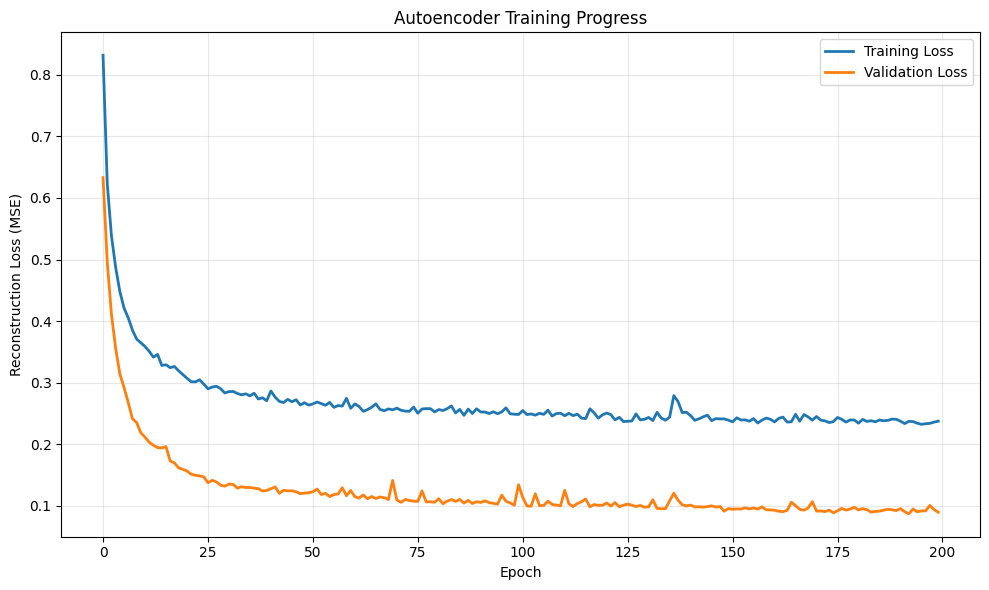

Final Training Loss: 0.237461
Final Validation Loss: 0.089614


In [11]:
# Plot autoencoder training curves
plt.figure(figsize=(10, 6))
plt.plot(ae_train_losses, label="Training Loss", linewidth=2)
plt.plot(ae_val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Autoencoder Training Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {ae_train_losses[-1]:.6f}")
print(f"Final Validation Loss: {ae_val_losses[-1]:.6f}")

## 4. DNN Classifier Head

Build a classifier that takes the encoder's latent representation as input.


In [12]:
class DNNClassifier(nn.Module):
    """
    Deep Neural Network classifier head.

    Takes latent representation Z from encoder and outputs fraud probability.
    """

    def __init__(self, latent_dim, hidden_dims=[32, 16]):
        super(DNNClassifier, self).__init__()

        layers = []
        input_dim = latent_dim

        for hidden_dim in hidden_dims:
            layers.extend(
                [
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_dim),
                    nn.Dropout(0.3),
                ]
            )
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))  # Output: fraud probability (logit)

        self.classifier = nn.Sequential(*layers)

    def forward(self, z):
        return self.classifier(z)


# Initialize classifier
classifier = DNNClassifier(latent_dim=latent_dim, hidden_dims=[32, 16]).to(device)
print(f"\nDNN Classifier Architecture:")
print(f"Input (Latent) dimension: {latent_dim}")
print(f"Hidden layers: [32, 16]")
print(f"Output: 1 (fraud probability)")
print(f"\nTotal parameters: {sum(p.numel() for p in classifier.parameters())}")


DNN Classifier Architecture:
Input (Latent) dimension: 16
Hidden layers: [32, 16]
Output: 1 (fraud probability)

Total parameters: 1185


## 5. AED-DNN Combined Model


In [13]:
class AED_DNN(nn.Module):
    """
    Combined Autoencoder-Encoder + DNN model.

    Pipeline:
    1. Input X → Encoder → Latent Z
    2. Latent Z → DNN Classifier → P(fraud)
    """

    def __init__(self, encoder, classifier):
        super(AED_DNN, self).__init__()
        self.encoder = encoder.encoder  # Use only the encoder part
        self.classifier = classifier

        # Freeze encoder initially (fine-tune later if needed)
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        return logits

    def unfreeze_encoder(self):
        """Allow fine-tuning of encoder weights"""
        for param in self.encoder.parameters():
            param.requires_grad = True


# Create combined model
aed_dnn = AED_DNN(autoencoder, classifier).to(device)
print("\nAED-DNN Model Created ✅")
print(f"Encoder frozen: {not next(aed_dnn.encoder.parameters()).requires_grad}")
print(f"Total parameters: {sum(p.numel() for p in aed_dnn.parameters())}")
print(
    f"Trainable parameters: {sum(p.numel() for p in aed_dnn.parameters() if p.requires_grad)}"
)


AED-DNN Model Created ✅
Encoder frozen: True
Total parameters: 5713
Trainable parameters: 1185


## 6. Custom Loss Function (Same as Original)

Use the business-aware cost function from the original notebook.


In [14]:
class ExpectedCostLoss(nn.Module):
    """
    Custom loss function that minimizes total business cost.
    """

    def __init__(
        self, abandonment_limit=0.1, user_lazy_factor=0.2, penalty_per_percent=10000
    ):
        super().__init__()
        self.limit = abandonment_limit
        self.lazy_factor = user_lazy_factor
        self.penalty_scaler = penalty_per_percent * 100

    def forward(self, logits, targets, amounts):
        # Get probabilities
        probs = torch.sigmoid(logits).squeeze()

        # Authentication cost (€1 per authentication)
        auth_cost = probs * 1.0

        # Missed fraud cost
        missed_fraud_cost = targets * (1 - probs) * amounts

        # Abandonment penalty
        avg_auth_rate = probs.mean()
        current_abandon_rate = avg_auth_rate * self.lazy_factor
        excess_abandonment = F.relu(current_abandon_rate - self.limit)
        abandonment_penalty = excess_abandonment * self.penalty_scaler

        # Total loss
        total_loss = (auth_cost + missed_fraud_cost).mean() + abandonment_penalty

        return total_loss


# Initialize loss and optimizer
criterion = ExpectedCostLoss()
optimizer = torch.optim.Adam(aed_dnn.parameters(), lr=1e-3)

print("Loss function and optimizer initialized ✅")

Loss function and optimizer initialized ✅


## 7. Stage 2: Train Classifier (Frozen Encoder)


In [15]:
def train_classifier(
    model,
    X_train,
    y_train,
    amt_train,
    X_val,
    y_val,
    amt_val,
    criterion,
    optimizer,
    epochs=100,
    batch_size=256,
):
    """
    Train the classifier head with frozen encoder.
    """
    train_losses = []
    val_losses = []

    N = X_train.shape[0]
    best_val_loss = float("inf")

    print("Training Classifier (Stage 2)...")

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(N)
        total_loss = 0.0

        for start in range(0, N, batch_size):
            idx = perm[start : start + batch_size]
            xb = X_train[idx]
            yb = y_train[idx]
            ab = amt_train[idx]

            # Forward
            logits = model(xb)
            loss = criterion(logits, yb, ab)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(xb)

        avg_train_loss = total_loss / N
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = criterion(val_logits, y_val, amt_val).item()
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Cost: €{val_loss:.2f}"
            )

    print(f"\nClassifier Training Complete!")
    print(f"Best Validation Cost: €{best_val_loss:.2f}")

    return train_losses, val_losses


# Train classifier
train_losses, val_losses = train_classifier(
    aed_dnn,
    X_train_t,
    y_train_t,
    amt_train_t,
    X_val_t,
    y_val_t,
    amt_val_t,
    criterion,
    optimizer,
    epochs=200,
    batch_size=512,
)

Training Classifier (Stage 2)...
Epoch 10/200 | Train Loss: 0.3719 | Val Cost: €0.37
Epoch 20/200 | Train Loss: 0.3388 | Val Cost: €0.37
Epoch 30/200 | Train Loss: 0.3362 | Val Cost: €0.35
Epoch 40/200 | Train Loss: 0.3203 | Val Cost: €0.36
Epoch 50/200 | Train Loss: 0.3069 | Val Cost: €0.34
Epoch 60/200 | Train Loss: 0.3170 | Val Cost: €0.30
Epoch 70/200 | Train Loss: 0.2947 | Val Cost: €0.38
Epoch 80/200 | Train Loss: 0.3126 | Val Cost: €0.38
Epoch 90/200 | Train Loss: 0.2809 | Val Cost: €0.38
Epoch 100/200 | Train Loss: 0.2920 | Val Cost: €0.38
Epoch 110/200 | Train Loss: 0.2979 | Val Cost: €0.39
Epoch 120/200 | Train Loss: 0.2840 | Val Cost: €0.38
Epoch 130/200 | Train Loss: 0.2978 | Val Cost: €0.40
Epoch 140/200 | Train Loss: 0.2933 | Val Cost: €0.35
Epoch 150/200 | Train Loss: 0.2971 | Val Cost: €0.37
Epoch 160/200 | Train Loss: 0.3224 | Val Cost: €0.33
Epoch 170/200 | Train Loss: 0.3108 | Val Cost: €0.34
Epoch 180/200 | Train Loss: 0.3007 | Val Cost: €0.40
Epoch 190/200 | Train 

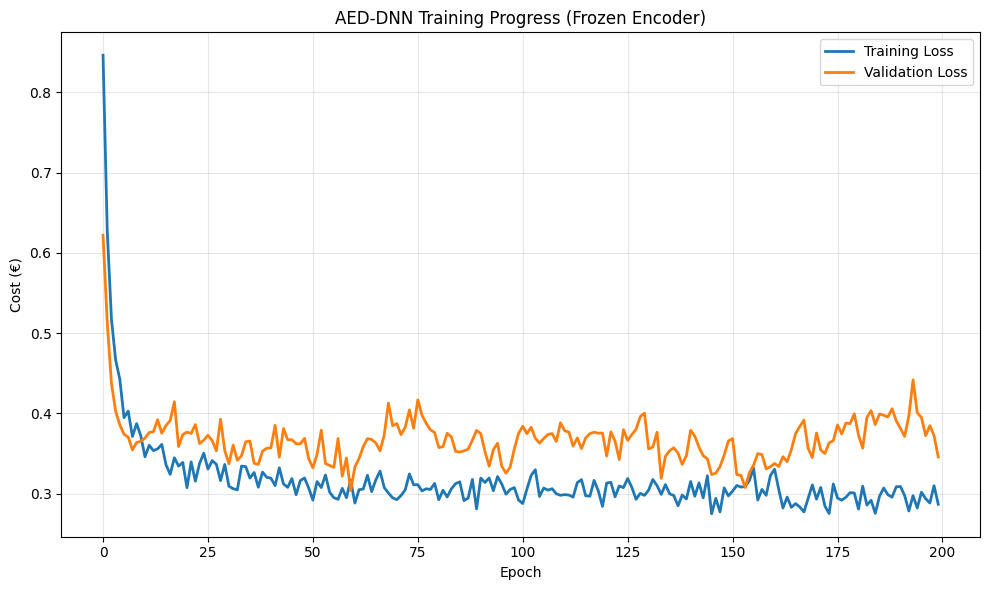

Final Training Loss: 0.2867
Final Validation Loss: €0.35


In [16]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Cost (€)")
plt.title("AED-DNN Training Progress (Frozen Encoder)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: €{val_losses[-1]:.2f}")

## 8. Optional: Fine-tune Entire Model

Unfreeze encoder and fine-tune end-to-end with lower learning rate.


In [17]:
# Unfreeze encoder for fine-tuning
aed_dnn.unfreeze_encoder()
print(f"Encoder unfrozen: {next(aed_dnn.encoder.parameters()).requires_grad}")
print(
    f"Trainable parameters: {sum(p.numel() for p in aed_dnn.parameters() if p.requires_grad)}"
)

# Use lower learning rate for fine-tuning
optimizer_finetune = torch.optim.Adam(aed_dnn.parameters(), lr=1e-4)

# Fine-tune
finetune_train_losses, finetune_val_losses = train_classifier(
    aed_dnn,
    X_train_t,
    y_train_t,
    amt_train_t,
    X_val_t,
    y_val_t,
    amt_val_t,
    criterion,
    optimizer_finetune,
    epochs=200,  # Fewer epochs for fine-tuning
    batch_size=512,
)

Encoder unfrozen: True
Trainable parameters: 5713
Training Classifier (Stage 2)...
Epoch 10/200 | Train Loss: 0.2546 | Val Cost: €0.32
Epoch 20/200 | Train Loss: 0.2656 | Val Cost: €0.29
Epoch 30/200 | Train Loss: 0.2405 | Val Cost: €0.25
Epoch 40/200 | Train Loss: 0.2383 | Val Cost: €0.24
Epoch 50/200 | Train Loss: 0.2215 | Val Cost: €0.26
Epoch 60/200 | Train Loss: 0.2230 | Val Cost: €0.24
Epoch 70/200 | Train Loss: 0.2165 | Val Cost: €0.23
Epoch 80/200 | Train Loss: 0.2163 | Val Cost: €0.24
Epoch 90/200 | Train Loss: 0.2177 | Val Cost: €0.24
Epoch 100/200 | Train Loss: 0.2184 | Val Cost: €0.24
Epoch 110/200 | Train Loss: 0.2203 | Val Cost: €0.24
Epoch 120/200 | Train Loss: 0.2034 | Val Cost: €0.25
Epoch 130/200 | Train Loss: 0.2080 | Val Cost: €0.24
Epoch 140/200 | Train Loss: 0.2212 | Val Cost: €0.24
Epoch 150/200 | Train Loss: 0.1983 | Val Cost: €0.23
Epoch 160/200 | Train Loss: 0.2096 | Val Cost: €0.23
Epoch 170/200 | Train Loss: 0.2017 | Val Cost: €0.23
Epoch 180/200 | Train Los

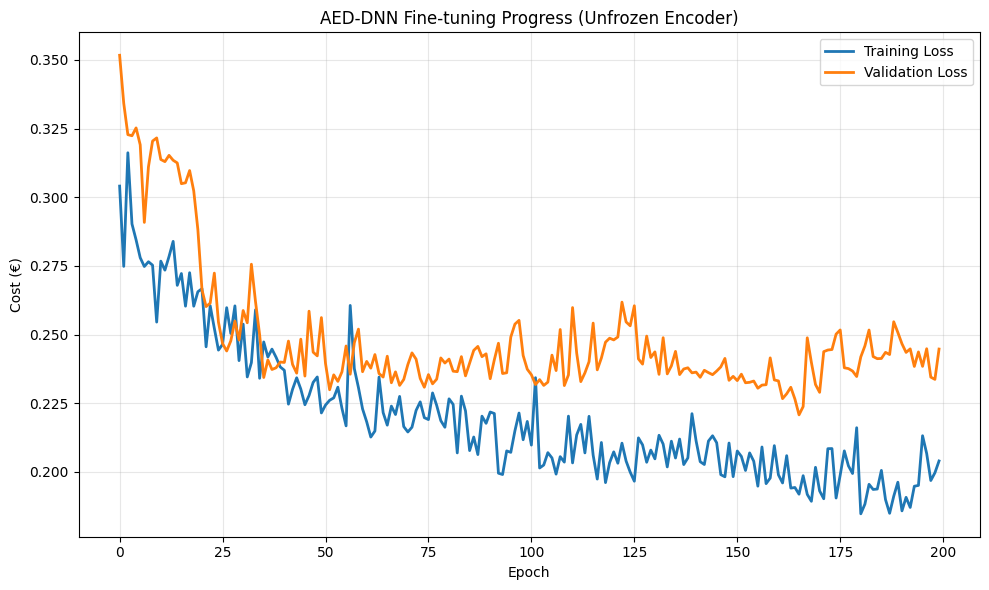

Final Training Loss: 0.2040
Final Validation Loss: €0.24


In [18]:
# Plot fine-tuning curves
plt.figure(figsize=(10, 6))
plt.plot(finetune_train_losses, label="Training Loss", linewidth=2)
plt.plot(finetune_val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Cost (€)")
plt.title("AED-DNN Fine-tuning Progress (Unfrozen Encoder)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {finetune_train_losses[-1]:.4f}")
print(f"Final Validation Loss: €{finetune_val_losses[-1]:.2f}")

## 9. Evaluation Functions


In [19]:
def calculate_bank_invoice(
    model,
    X_tensor,
    y_true,
    amounts,
    threshold=0.5,
    high_value_threshold=500,
    low_value_threshold=1,
):
    """
    Calculate total business cost with hardcoded business rules.
    """
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    # Convert tensors to numpy for easier manipulation
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()
    if torch.is_tensor(amounts):
        amounts = amounts.cpu().numpy()

    # Make predictions based on threshold
    preds = (probs >= threshold).astype(int)
    model_flags = preds.copy()
    model_flag_count = model_flags.sum()

    # Business rules
    high_value_mask = amounts >= high_value_threshold
    preds[high_value_mask] = 1

    low_value_mask = amounts < low_value_threshold
    preds[low_value_mask] = 0

    total_transactions = len(y_true)

    # 1. Authentication costs
    auth_count = (preds == 1).sum()
    auth_fee = auth_count * 1.0

    # 2. Missed fraud costs
    missed_indices = np.where((preds == 0) & (y_true == 1))[0]
    missed_fraud_cost = amounts[missed_indices].sum()

    # 3. Abandonment penalty
    abandon_rate = (auth_count * 0.2) / total_transactions
    excess = max(0, abandon_rate - 0.10)
    abandon_penalty = 10000 * (excess * 100)

    total_cost = auth_fee + missed_fraud_cost + abandon_penalty

    high_value_auto_count = high_value_mask.sum()
    low_value_auto_skip = low_value_mask.sum()

    print(f"--- FINAL BANK INVOICE ---")
    print(f"Auth Requested:     {auth_count} (€{auth_fee:.2f})")
    print(f"  ↳ Auto-flagged (>€{high_value_threshold}): {high_value_auto_count}")
    print(f"  ↳ Auto-skipped (<€{low_value_threshold}): {low_value_auto_skip}")
    print(f"Model-flagged Auth Requests: {model_flag_count}")
    print(f"Missed Fraud Cost:  €{missed_fraud_cost:,.2f}")
    print(f"Abandonment Rate:   {abandon_rate:.2%} (Penalty: €{abandon_penalty:,.2f})")
    print(f"--------------------------")
    print(f"TOTAL COST:         €{total_cost:,.2f}")

    return total_cost, preds


def find_optimal_threshold(model, X_tensor, y_true, amounts):
    """
    Search for threshold that minimizes total cost.
    """
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_tensor)).squeeze().cpu().numpy()

    # Convert to numpy
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()
    if torch.is_tensor(amounts):
        amounts = amounts.cpu().numpy()

    best_cost = float("inf")
    best_threshold = 0.0

    for thresh in np.linspace(0, 1, 101):
        preds = (probs >= thresh).astype(int)

        auth_count = preds.sum()
        auth_fee = auth_count * 1.0

        missed_indices = np.where((preds == 0) & (y_true == 1))[0]
        missed_fraud_cost = amounts[missed_indices].sum()

        abandon_rate = (auth_count * 0.2) / len(y_true)
        excess = max(0, abandon_rate - 0.10)
        abandon_penalty = 10000 * (excess * 100)

        total_cost = auth_fee + missed_fraud_cost + abandon_penalty

        if total_cost < best_cost:
            best_cost = total_cost
            best_threshold = thresh

    return best_threshold, best_cost


print("Evaluation functions defined ✅")

Evaluation functions defined ✅


## 10. Test Set Evaluation


In [20]:
# Find optimal threshold on validation set
opt_thresh, opt_cost = find_optimal_threshold(aed_dnn, X_val_t, y_val_t, amt_val_t)
print(f"Optimal Threshold (from validation): {opt_thresh:.4f}")
print(f"Expected Validation Cost: €{opt_cost:.2f}\n")

Optimal Threshold (from validation): 0.0800
Expected Validation Cost: €7651.77



In [21]:
# Evaluate on test set with optimal threshold
print("=" * 50)
print("TEST SET EVALUATION")
print("=" * 50)

total_cost, final_preds = calculate_bank_invoice(
    aed_dnn,
    X_test_t,
    y_test_t,
    amt_test_t,
    threshold=0.001,
    high_value_threshold=500,
    low_value_threshold=3,
)

TEST SET EVALUATION
--- FINAL BANK INVOICE ---
Auth Requested:     3663 (€3663.00)
  ↳ Auto-flagged (>€500): 1095
  ↳ Auto-skipped (<€3): 6359
Model-flagged Auth Requests: 3781
Missed Fraud Cost:  €2,722.10
Abandonment Rate:   2.23% (Penalty: €0.00)
--------------------------
TOTAL COST:         €6,385.10


## 11. Additional Metrics



=== Standard ML Metrics ===
Accuracy:  0.8885
Precision: 0.0568
Recall:    0.4952
F1 Score:  0.1019
ROC AUC:   0.7757


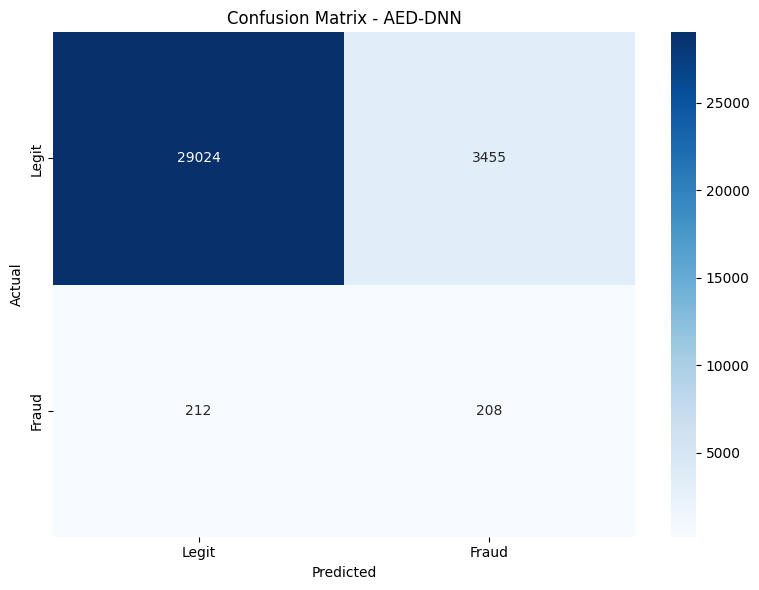

In [22]:
# Calculate standard ML metrics
y_test_np = y_test_t.cpu().numpy() if torch.is_tensor(y_test_t) else y_test_t

with torch.no_grad():
    test_probs = torch.sigmoid(aed_dnn(X_test_t)).squeeze().cpu().numpy()

accuracy = accuracy_score(y_test_np, final_preds)
precision = precision_score(y_test_np, final_preds)
recall = recall_score(y_test_np, final_preds)
f1 = f1_score(y_test_np, final_preds)
auc = roc_auc_score(y_test_np, test_probs)

print(f"\n=== Standard ML Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_np, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legit", "Fraud"],
    yticklabels=["Legit", "Fraud"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AED-DNN")
plt.tight_layout()
plt.show()

## 12. Latent Space Visualization


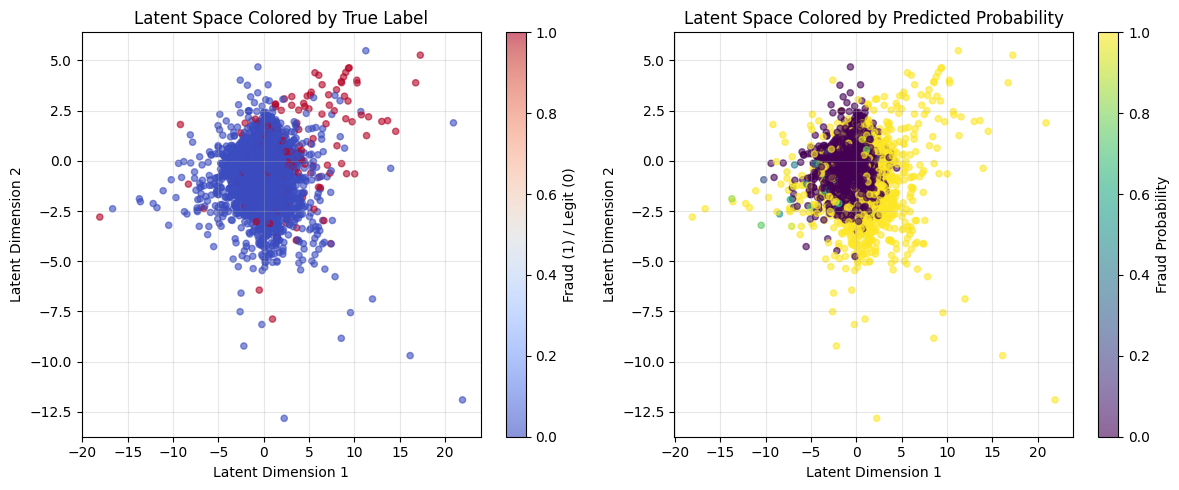

In [23]:
# Extract latent representations for test set
aed_dnn.eval()
with torch.no_grad():
    test_latent = aed_dnn.encoder(X_test_t).cpu().numpy()

# Visualize first 2 dimensions of latent space
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(
    test_latent[:, 0], test_latent[:, 1], c=y_test_np, cmap="coolwarm", alpha=0.6, s=20
)
plt.colorbar(scatter, label="Fraud (1) / Legit (0)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by True Label")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(
    test_latent[:, 0], test_latent[:, 1], c=test_probs, cmap="viridis", alpha=0.6, s=20
)
plt.colorbar(scatter, label="Fraud Probability")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by Predicted Probability")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Model Comparison Summary


In [24]:
print("\n" + "=" * 60)
print("MODEL SUMMARY: AED-DNN")
print("=" * 60)
print(f"\nArchitecture:")
print(f"  - Autoencoder: {input_dim} → {hidden_dim} → {latent_dim}")
print(f"  - Classifier: {latent_dim} → [32, 16] → 1")
print(f"  - Total Parameters: {sum(p.numel() for p in aed_dnn.parameters())}")
print(f"\nTraining:")
print(f"  - Stage 1: Autoencoder pre-training (100 epochs)")
print(f"  - Stage 2: Classifier training with frozen encoder (100 epochs)")
print(f"  - Stage 3: End-to-end fine-tuning (50 epochs)")
print(f"\nTest Performance:")
print(f"  - Total Cost: €{total_cost:,.2f}")
print(f"  - F1 Score: {f1:.4f}")
print(f"  - ROC AUC: {auc:.4f}")
print(f"  - Optimal Threshold: {opt_thresh:.4f}")
print("=" * 60)


MODEL SUMMARY: AED-DNN

Architecture:
  - Autoencoder: 29 → 64 → 16
  - Classifier: 16 → [32, 16] → 1
  - Total Parameters: 5713

Training:
  - Stage 1: Autoencoder pre-training (100 epochs)
  - Stage 2: Classifier training with frozen encoder (100 epochs)
  - Stage 3: End-to-end fine-tuning (50 epochs)

Test Performance:
  - Total Cost: €6,385.10
  - F1 Score: 0.1019
  - ROC AUC: 0.7757
  - Optimal Threshold: 0.0800


In [55]:
total_cost, final_preds = calculate_bank_invoice(
    aed_dnn,
    torch.tensor(X, dtype=torch.float32),
    y,  # Use the numpy array for y_true
    amounts,  # Use the numpy array for amounts
    threshold=0.1,
    high_value_threshold=10000,
    low_value_threshold=22,
)

--- FINAL BANK INVOICE ---
Auth Requested:     82201 (€82201.00)
  ↳ Auto-flagged (>€10000): 3
  ↳ Auto-skipped (<€22): 82291
Model-flagged Auth Requests: 146345
Missed Fraud Cost:  €4,197.74
Abandonment Rate:   9.99% (Penalty: €0.00)
--------------------------
TOTAL COST:         €86,398.74
